In [1]:
#IMPORT LIBRARIES
import sqlite3
import os
import pandas as pd
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, DBSCAN, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from itertools import product
from math import ceil
from scipy.cluster.hierarchy import dendrogram
%matplotlib inline
#from pandas_profiling import ProfileReport 
%config InlineBackend.figure_format = 'retina' 
from scipy.stats import iqr as IQR
from collections import Counter
import scipy.stats as stat
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import coo_matrix

from tqdm import tqdm

# Seeting seaborn style
sns.set()

In [2]:
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import ranking_metrics_at_k


Collect initial data

In [3]:
#import file csv
df = pd.read_csv('retail.csv')
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

### Describe, explore and assess data quality

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
df.replace("", np.nan, inplace=True)

In [8]:
# Summary statistics for all variables
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
InvoiceNo,541909,25900,573585,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,541909,4070,85123A,2313,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,541909,NaN,NaN,NaN,9.55225,218.081,-80995,1,3,10,80995
InvoiceDate,541909,23260,10/31/2011 14:41,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,541909,NaN,NaN,NaN,4.61111,96.7599,-11062.1,1.25,2.08,4.13,38970
CustomerID,406829,NaN,NaN,NaN,15287.7,1713.6,12346,13953,15152,16791,18287
Country,541909,38,United Kingdom,495478,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#FUNCTION TO SHOW MISSING VALUES AND THEIR PERCENTAGES
def missing_data(df):
    l = []
    for col in df.columns:
        missing = df[col].isnull().sum(axis=0)
        percentage = missing/df.shape[0]
        l.append([col,missing,percentage*100])
        df_missing = pd.DataFrame(l, columns = ['Feature','missing','percentage'])
        df_missing = df_missing.sort_values('missing',axis=0, ascending = False)    
    return df_missing

In [10]:
df_missing = missing_data(df)
df_missing = df_missing[df_missing['missing']>0]
df_missing

,Feature,missing,percentage
6,CustomerID,135080,24.926694
2,Description,1454,0.268311


In [11]:
# Check duplicated observations
df.loc[df.duplicated(keep=False), :]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom


In [12]:
df1 = df.copy()

## Data Preparation:

### Clean data

In [13]:
# Droping duplicated rows
df1.drop_duplicates(inplace=True)

In [14]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [15]:
# Droping irelevant columns
#df1['StockCode'].drop(['POST'], axis=0, inplace=True)
df1= df1[~  df1['StockCode'].isin(['DCGS0076','DCGS0003',
'DCGS0070',
'DCGS0055', 
'DCGS0072', 
'DCGS0074', 
'DCGS0069', 
'DCGS0057', 
'DCGSSBOY', 
'DCGSSGIRL', 
'DCGS0004', 
'DCGS0073', 
'DCGS0071', 
'DCGS0068', 
'DCGS0067', 
'DCGS0066P', 
'POST', 
'D', 
'DOT', 
'M', 
'BANK CHARGES', 
'S', 
'AMAZONFEE', 
'gift_0001_40', 
'gift_0001_50', 
'gift_0001_30', 
'gift_0001_20', 
'gift_0001_10', 
'PADS', 
'B', 
'CRUK', 
'C2',
'm'
])]

In [16]:
#Remove transactions with price =0.  
df1 = df1[df1['UnitPrice']>0]

In [17]:
print('Percentage of data kept after removing outliers:', np.round(df1.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9802


In [18]:
df1['Country'].value_counts()
#keep Unspecified because doesnt affect the collaborative filtering algorithm

United Kingdom          486167
Germany                   9080
France                    8218
EIRE                      8059
Spain                     2462
Netherlands               2326
Belgium                   1971
Switzerland               1960
Portugal                  1466
Australia                 1253
Norway                    1059
Italy                      783
Channel Islands            752
Finland                    653
Cyprus                     608
Unspecified                442
Sweden                     436
Austria                    387
Denmark                    375
Japan                      355
Poland                     336
Israel                     294
USA                        291
Hong Kong                  276
Singapore                  215
Iceland                    182
Canada                     150
Greece                     142
Malta                      123
United Arab Emirates        67
European Community          58
RSA                         57
Lebanon 

In [19]:
df_missing = missing_data(df1)
df_missing = df_missing[df_missing['missing']>0]
df_missing

,Feature,missing,percentage
6,CustomerID,131516,24.759588


In [20]:
# get max CustomerID
idMax = df1['CustomerID'].max()



# get distinct invoice numbers for records where CustomerID is null
invoicesNullCustomer = df1[df1['CustomerID'].isnull()]['InvoiceNo'].unique()



next_customerId = idMax+1
for invoiceNo in invoicesNullCustomer:
    df1.loc[df1['InvoiceNo'] == invoiceNo, 'CustomerID'] = next_customerId
    next_customerId +=1


In [21]:
df_missing = missing_data(df1)
df_missing = df_missing[df_missing['missing']>0]
df_missing

,Feature,missing,percentage


In [22]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531172 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    531172 non-null  object 
 1   StockCode    531172 non-null  object 
 2   Description  531172 non-null  object 
 3   Quantity     531172 non-null  int64  
 4   InvoiceDate  531172 non-null  object 
 5   UnitPrice    531172 non-null  float64
 6   CustomerID   531172 non-null  float64
 7   Country      531172 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.5+ MB


In [23]:
df1['InvoiceDate'] = df1['InvoiceDate'].astype('datetime64[ns]')
df1['Month_Year'] = df1['InvoiceDate'].dt.strftime('%Y-%m')
df1

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month_Year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12


In [24]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531172 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    531172 non-null  object        
 1   StockCode    531172 non-null  object        
 2   Description  531172 non-null  object        
 3   Quantity     531172 non-null  int64         
 4   InvoiceDate  531172 non-null  datetime64[ns]
 5   UnitPrice    531172 non-null  float64       
 6   CustomerID   531172 non-null  float64       
 7   Country      531172 non-null  object        
 8   Month_Year   531172 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 40.5+ MB


In [25]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
InvoiceNo,541909,25900,573585,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,541909,4070,85123A,2313,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,541909,NaN,NaN,NaN,9.55225,218.081,-80995,1,3,10,80995
InvoiceDate,541909,23260,10/31/2011 14:41,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,541909,NaN,NaN,NaN,4.61111,96.7599,-11062.1,1.25,2.08,4.13,38970
CustomerID,406829,NaN,NaN,NaN,15287.7,1713.6,12346,13953,15152,16791,18287
Country,541909,38,United Kingdom,495478,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Visualization/Correlations

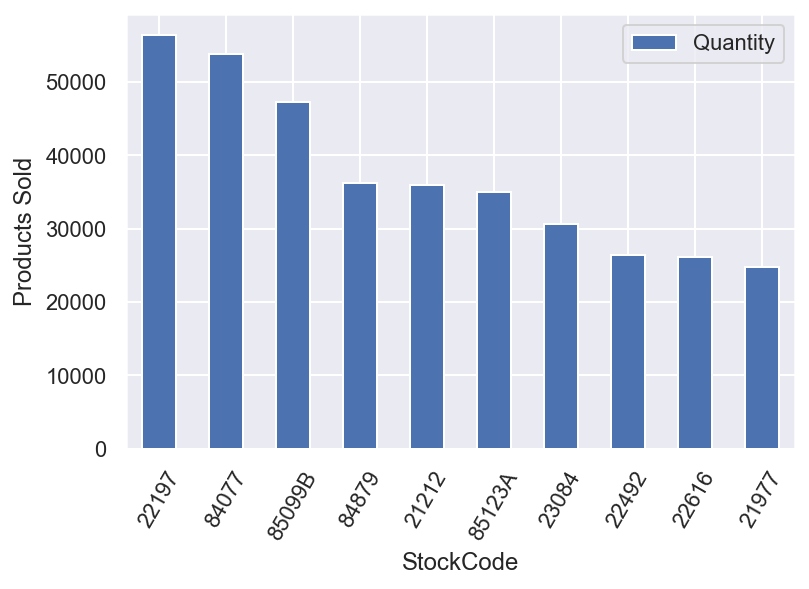

In [26]:
#FINDING THE MOST SELLING PRODUCTS


best_selling_prods = pd.DataFrame(df1.groupby('StockCode').sum()['Quantity'].sort_values(ascending = False)).head(10)

best_selling_prods = best_selling_prods.head(10)
best_selling_prods.reset_index(level=0, inplace=True)
best_selling_prods


top10products=best_selling_prods.plot(x='StockCode', rot=60, kind='bar')
top10products.set_ylabel('Products Sold')
plt.show()


In [27]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month_Year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12


In [38]:
#FINDING FIRST PURCHASE FOR EACH CUSTOMER
first_purchase=df1.sort_values('InvoiceDate').groupby(['CustomerID'])['InvoiceDate', 'StockCode'].first().reset_index()
first_purchase

<ipython-input-38-551d2a0cc9af>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  first_purchase=df1.sort_values('InvoiceDate').groupby(['CustomerID'])['InvoiceDate', 'StockCode'].first().reset_index()


,CustomerID,InvoiceDate,StockCode
0,12346.0,2011-01-18 10:01:00,23166
1,12347.0,2010-12-07 14:57:00,84997C
2,12348.0,2010-12-16 19:09:00,84988
3,12349.0,2011-11-21 09:51:00,22704
4,12350.0,2011-02-02 16:01:00,22620
...,...,...,...
5767,19693.0,2011-12-08 16:14:00,72801D
5768,19694.0,2011-12-08 16:30:00,22580
5769,19695.0,2011-12-09 10:03:00,22549
5770,19696.0,2011-12-09 10:23:00,23168


In [39]:
#FINDING THE MOST COMMON PRODUCT BOUGHT IN THE FIRST PURCHASE
first_most_common_item= first_purchase['StockCode'].value_counts().head(10)
first_most_common_item

22423     50
85123A    42
85099B    37
47566     30
21034     27
22960     24
22666     22
22961     21
22457     20
84946     20
Name: StockCode, dtype: int64

In [35]:
#FINDING THE MOST SELLING PRODUCT BY COUNTRY(errado)
best_selling_prods_country = df1.groupby(['Country', 'StockCode'])['Quantity'].agg('sum').reset_index()


max_selling_prods_country = best_selling_prods_country.groupby("Country").max()
max_selling_prods_country

#top10productsbycountry=best_selling_prods.plot(x='Country', y='Quantity', rot=60, kind='bar')
#plt.show()

,StockCode,Quantity
Country,,
Australia,85183B,2916
Austria,90013A,288
Bahrain,85040A,96
Belgium,90164A,480
Brazil,84971S,24
Canada,85232D,504
Channel Islands,85150,407
Cyprus,85232D,384
Czech Republic,85206A,72


([<matplotlib.axis.XTick at 0x1fa1b62a550>,
 [Text(0, 0, 'Dec-2010'),
  Text(0, 0, 'Jan-2011'),
  Text(0, 0, 'Feb-2011'),
  Text(0, 0, 'Mar-2011'),
  Text(0, 0, 'Apr-2011'),
  Text(0, 0, 'May-2011'),
  Text(0, 0, 'Jun-2011'),
  Text(0, 0, 'Jul-2011'),
  Text(0, 0, 'Aug-2011'),
  Text(0, 0, 'Sep-2011'),
  Text(0, 0, 'Oct-2011'),
  Text(0, 0, 'Nov-2011'),
  Text(0, 0, 'Dec-2011')])

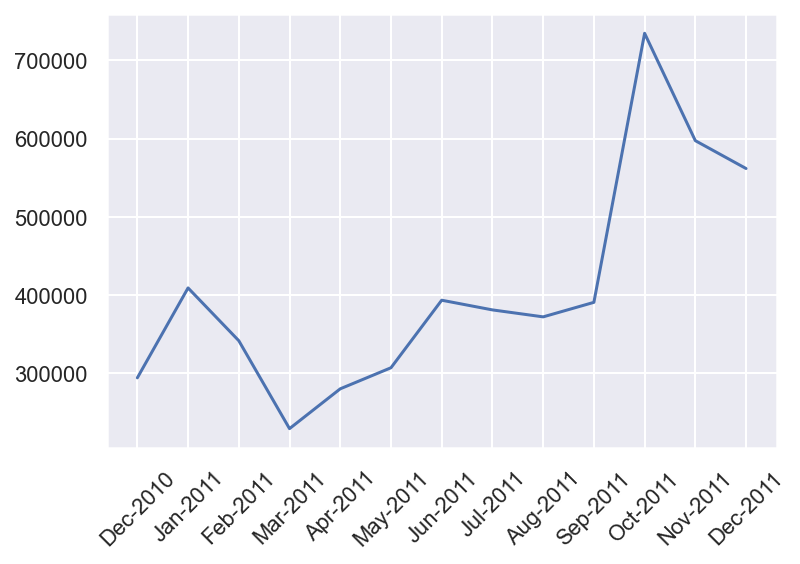

In [36]:
import calendar
by_month=df1.groupby(['Country', 'StockCode','InvoiceDate'])['Quantity'].agg('sum').reset_index()
by_month['Month']=pd.DatetimeIndex(by_month['InvoiceDate']).month
by_month['Year']=pd.DatetimeIndex(by_month['InvoiceDate']).year
by_month['Month_Name'] = by_month['Month'].apply(lambda x: calendar.month_abbr[x])
by_month['Time_Series']=by_month['Month_Name']+'-'+by_month['Year'].astype(str)
by_month=by_month.groupby(['Time_Series'])['Quantity'].agg('sum').reset_index()
x_label=['Dec-2010','Jan-2011','Feb-2011','Mar-2011','Apr-2011','May-2011','Jun-2011','Jul-2011','Aug-2011','Sep-2011','Oct-2011','Nov-2011','Dec-2011']

plt.figure()
plt.plot(x_label,by_month['Quantity'])
plt.xticks(np.arange(13), x_label, rotation=45)

In [ ]:
df1.head()

In [ ]:
#Create a dataframe grouped by user id
number_orders = df1['CustomerID'].value_counts()
#Sort the values by the user with highest number of orders
number_orders = number_orders.sort_values(ascending=False,axis=0)
#Reset index
number_orders = number_orders.reset_index()
#Rename columns
number_orders.rename(columns={'index': 'number_user'}, inplace = True)
number_orders.rename(columns={'CustomerID': 'number_orders'}, inplace = True)
#Group the dataframe by quantity of users according by number of orders placed
number_orders= number_orders.groupby("number_orders")['number_user'].agg(['count'])
#Reset index
number_orders = number_orders.reset_index()
#Show
number_orders

In [ ]:
#plt.subplots(figsize=(10,6))
number_orders.plot.line(x='number_orders', y='count', figsize=(10,7))
plt.xlabel('Number of orders')
plt.ylabel('Quantity of Customers')
plt.title('Number of Orders for different Customers')
plt.show()

In [ ]:
number_orders.plot.scatter(x='number_orders', y='count', figsize=(10,7))
plt.xlabel('Number of orders')
plt.ylabel('Quantity of Customers')
plt.title('Number of Orders for different Customers')
plt.show()

In [ ]:
#FINDING PRODUCTS THAT WERE BOUGHT JUST ONCE
onetime = df1.loc[df1['Quantity'] == 1]
onetimeproduct=onetime.drop_duplicates(subset ="StockCode")
onetimeproduct

In [ ]:
#CANCELED ITEMS
cancelitems= df1.loc[df1['Quantity'] < 0]
#cancelitemsproduct=cancelitems.drop_duplicates(subset ="StockCode")
cancelitems

In [ ]:
#MOST CANCELS ITEMS
cancelitems= df1.loc[df1['Quantity'] < 0]
cancelitemsprod=cancelitems.groupby('StockCode').sum()['Quantity'].reset_index().head(10)

cancelitemsprod['Quantity']=cancelitemsprod['Quantity']*-1
cancelitemsprod.sort_values(by='Quantity', ascending=False)
cancelitemsprod

In [ ]:
top10cancelitems=cancelitemsprod.plot(x='StockCode', y='Quantity', rot=60, kind='bar')
top10cancelitems.set_title('Top 10 products cancelled')
top10cancelitems.set_xlabel('ProductID')
top10cancelitems.set_ylabel('Quantity of cancelled products')

In [ ]:
#FINDING MOST COMMOM CANCELLED PRODUCT BY COUNTRY
cancelcountry=cancelitems.groupby(['Country','StockCode'])['Quantity'].agg('sum').reset_index()
#cancelproductspercountry = cancelcountry.loc[cancelcountry.groupby('Country', as_index=False)['Quantity'].idxmin()]
#cancelproductspercountry

min_cancelcountry=cancelcountry.groupby(['Country']).min()
min_cancelcountry['Quantity']=min_cancelcountry['Quantity']*-1
min_cancelcountry
#cancelcountry.groupby(['Country','StockCode'])
#cancelcountry.sort_values(by='Quantity', ascending=True).head(10)
#cancelcountry

### Reduce sparsity

## CREATE MATRIX AND SPLIT DATA TRAIN AND TEST
